# Funathon 2023 - Sujet 5

Responsables :
- Antoine Palazzolo, SSP Lab
- Romain Avouac, DIIT

# Analyse textuelle des commentaires clients de services de commande de repas en ligne

## Avant de commencer...

Ce sujet, disponible uniquement en Python, porte sur deux thématiques principales :
- Le web scraping
- Le NLP

Les deux parties sont indépendantes l'une de l'autre, il est donc possible de n'en faire qu'une des deux.

Si jamais vous n'êtes pas familiers avec l'un de ces sujets (ou les deux), nous ne saurions que trop vous recommander de jeter un oeil aux ressources suivantes :
- Débuter en web scraping : https://pythonds.linogaliana.fr/webscraping/
- Web scraping et bonnes pratiques : https://github.com/InseeFrLab/formation-webscraping
- Débuter en NLP : https://pythonds.linogaliana.fr/course/nlp/

Exécutez la cellule ci-dessous pour installer les packages nécessaires au sujet :

In [2]:
!pip install --quiet -r requirements.txt

## Partie 1 : Scraping d'avis sur Trustpilot

Premier point de contact : Antoine Palazzolo

Pour pouvoir faire de l'analyse textuelle de commentaires clients, la première chose dont nous avons besoin c'est justement d'une base d'avis et de commentaires.
Vous pourrez trouver de tels avis sur à peu près n'importe quel site de vente en ligne ou bien sur un certain nombre de comparateurs.
En revanche, comment récupérer l'information depuis une page Internet pour nous constituer un jeu de données sur lequel travailler ?

Eh bien c'est justement là qu'intervient le web scraping, qui permet de collecter automatiquement de l'information d'un site web, que ce soit du texte, des images, des tableaux, sans avoir à parcourir toutes les pages soi-même en faisant un copier-coller à la main du contenu.
Le web scraping est donc un outil très puissant, mais à utiliser avec des pincettes.
Cela doit plutôt être vu comme un dernier recours, lorsqu'il n'est pas possible d'accéder aux données plus facilement.

En effet, de nombreuses contraintes juridiques encadrent par exemple le webscraping, il n'est pas possible de faire ce que l'on veut.
Qui plus est, de plus en plus de sites apprennent à se défendre contre cette collecte automatique de leurs données, rendant la tâche plus difficile.
Pour en savoir plus sur ces thématiques, n'hésitez pas à consulter cette formation : https://inseefrlab.github.io/formation-webscraping/.

<br>

Les données mises à disposition pour ce sujet ont été extraites du site https://fr.trustpilot.com/.
Votre première tâche va être de créer votre propre scraper pour pouvoir recréer une base similaire.

Afin de ne pas surcharger le traffic du site, nous n'allons pas vous demander d'en scraper l'intégralité.
Vous allez donc vous limiter à une entreprise de votre choix parmi celles de la catégorie _takeaway_ : https://fr.trustpilot.com/categories/takeaway.
Cliquez sur le lien et promenez-vous sur le site.

### 1. Bien préparer son scraping : découvrir le site ciblé

La première chose à faire pour tout bon adepte de scraping, c'est apprendre à connaître la page web cible :
- A quoi ressemble l'url du site ? Y a-t-il un radical commun lorsque l'on passe d'une page à une autre ? Par exemple ici lorsque l'on change d'entreprise comparée ou que l'on va chercher les avis les plus reculés ?
- Quelles sont les informations disponibles sur la page ? Y a-t-il besoin de cliquer sur un bouton pour les faire apparaître ?
- Les différentes pages que je souhaite scraper ont-elles bien des formats similaires ? La construction des pages change-t-elle d'une entreprise comparée à une autre ?

<br>

Il faut ensuite aller un peu plus loin dans l'analyse et regarder la structure HTML de la page ciblée.
Si vous n'êtes pas familiers avec cette partie, n'hésitez pas à consulter les ressources précédemment citées.

Tout d'abord, choisissez l'entreprise dont vous allez extraire les commentaires et cliquez sur sa page Trustpilot.
A présent, après un clic droit sur un élément de la page, il suffit de cliquer sur "Inspecter l'élément" pour naviguer dans l'architecture de la page et analyser le positionnement de l'élément sélectionné.
Cliquez sur divers éléments de la page pour vous familiariser avec sa structure.
- Comment sont rangés les commentaires ? Comprenez-vous bien l'arborescence de la page ?
- Regardez les balises autour de chaque note, y a-t-il un pattern ou un élément commun qui permet de les identifier et les distinguer des autres ?

### 2. Premiers pas : récupérer l'information du nombre de pages

#### Variables globales

In [27]:
radical_trustpilot = 'https://fr.trustpilot.com/review/' # TODO
company = 'www.leschocolatsducoeur.fr' # TODO

url_company = radical_trustpilot + company

Maintenant que vous avez votre premier lien à scraper, il va falloir envoyer une __requête__ au site pour demander à en récupérer le contenu, sous le format HTML.
C'est sur le contenu retourné que nous travaillerons ensuite.

En Python, un package permet facilement de faire ces requêtes, il s'agit de _requests_, et plus précisément de la fonction ```requests.get()```, qui prend en argument l'url ciblé.
En plus du lien à requêter, la fonction peut prendre d'autres arguments, appelés __headers__, comme _User_Agent_ ou _From_ qui permettent de s'identifier lors de la requête envoyée au site.

Pourquoi s'identifier me demanderez-vous ? Eh bien tout d'abord parce qu'il s'agit là d'une bonne pratique de scraping.
Les sites reçoivent parfois énormément de requêtes sur leurs pages, par exemple à cause de scrapers trop gourmands, et cela peut leur créer des problèmes.
Ils peuvent donc être amenés à par exemple bloquer les adresses IP des utilisateurs jugés abusifs.
S'identifier clairement dans ses requêtes, en explicitant le but de la collecte, permet de faire preuve de transparence.
Même si en pratique cela n'arrive que très peu, cela laisse alors la possibilité au propriétaire du site de contacter le scraper afin d'avoir plus d'informations sur le but de la collecte, et possiblement offrir l'accès aux données sans scraping.

Une autre bonne pratique pour ne pas être trop agressif vis-à-vis du site scrapé est d'étaler ses requêtes dans le temps, par exemple en forçant votre code à prendre une pause d'au moins 3 secondes entre chaque requête effectuée si vous visitez plusieurs pages.

Ici, complétez les headers ci-dessous avec vos informations pour faire preuve de transparence auprès de Trustpilot :

In [6]:
headers = {
    'User-Agent': 'INSEE, Funathon', # Nom, entité, but de la collecte, informations pertinentes
    'From': 'wistan.pomel@insee.fr' # Coordonnées à laisser au propriétaire du site en cas de besoin
}

Nous réutiliserons ces headers dans toutes les requêtes du sujet.

#### Créer sa première requête

In [7]:
import requests
import time

Utilisez la fonction ```requests.get()``` et vos headers pour requêter votre site, puis utilisez la méthode ```.text``` pour récupérer le contenu HTML de la page désirée sous forme de texte.

Vous pouvez aussi déjà prendre le réflexe d'ajouter un ```time.sleep(3)``` à l'issue de chaque requête effectuée pour ne pas surcharger le site lorsque nous aurons davantage de requêts à faire.

In [14]:
request_text = requests.get(url_company, headers = headers).text # TODO
time.sleep(3)
print(request_text)

<!DOCTYPE html><html lang="fr-FR"><head><meta charSet="UTF-8"/><meta name="viewport" content="width=device-width, initial-scale=1"/><link rel="shortcut icon" type="image/x-icon" href="https://cdn.trustpilot.net/brand-assets/1.5.0/favicons/favicon.ico"/><link rel="manifest" href="/manifest.json"/><meta name="application-name" content="Trustpilot"/><meta name="theme-color" content="#1c1c1c"/><link rel="apple-touch-icon" sizes="180x180" href="https://cdn.trustpilot.net/brand-assets/1.5.0/favicons/apple-touch-icon.png"/><link rel="icon" type="image/png" sizes="32x32" href="https://cdn.trustpilot.net/brand-assets/1.5.0/favicons/favicon-32x32.png"/><link rel="icon" type="image/png" sizes="16x16" href="https://cdn.trustpilot.net/brand-assets/1.5.0/favicons/favicon-16x16.png"/><link rel="mask-icon" href="https://cdn.trustpilot.net/brand-assets/1.9.0/favicons/safari-pinned-tab.svg" color="#00b67a"/><meta name="apple-mobile-web-app-title" content="Trustpilot"/><meta name="msapplication-TileColor

Si vous avez bien fait les choses, vous devriez maintenant avoir quelque chose d'assez illisible, c'est normal.
Il va maintenant falloir faire appel à un autre package pour __parser__ cette chaîne de caractères en une arborescence plus exploitable.

#### Parsing d'un document HTML : BeautifulSoup

La fonction ```BeautifulSoup()```, du package du même nom, est ce qui va nous permettre de faire ce parsing.
Rien de tel que l'essayer sur notre texte pour voir quel est son effet :

In [18]:
from bs4 import BeautifulSoup

In [20]:
soup = BeautifulSoup(request_text, 'html.parser') # TODO

print(soup.prettify())

<!DOCTYPE html>
<html lang="fr-FR">
 <head>
  <meta charset="utf-8"/>
  <meta content="width=device-width, initial-scale=1" name="viewport"/>
  <link href="https://cdn.trustpilot.net/brand-assets/1.5.0/favicons/favicon.ico" rel="shortcut icon" type="image/x-icon"/>
  <link href="/manifest.json" rel="manifest"/>
  <meta content="Trustpilot" name="application-name"/>
  <meta content="#1c1c1c" name="theme-color"/>
  <link href="https://cdn.trustpilot.net/brand-assets/1.5.0/favicons/apple-touch-icon.png" rel="apple-touch-icon" sizes="180x180"/>
  <link href="https://cdn.trustpilot.net/brand-assets/1.5.0/favicons/favicon-32x32.png" rel="icon" sizes="32x32" type="image/png"/>
  <link href="https://cdn.trustpilot.net/brand-assets/1.5.0/favicons/favicon-16x16.png" rel="icon" sizes="16x16" type="image/png"/>
  <link color="#00b67a" href="https://cdn.trustpilot.net/brand-assets/1.9.0/favicons/safari-pinned-tab.svg" rel="mask-icon"/>
  <meta content="Trustpilot" name="apple-mobile-web-app-title"/

Normalement ça a déjà une meilleure tête !
On dira que le contenu HTML est désormais sous la forme d'une _soupe_.
L'idée maintenant va être de naviguer parmi l'arborescence des balises dans cette _soupe_ pour aller chercher l'information que l'on souhaite.

#### Chercher un élément dans l'arborescence

Deux méthodes sont particulièrement utiles lorsque l'on travaille avec BeautifulSoup :

- ```soup.find(type_de_balise, {'class': classe_de_la_balise)```, pour trouver le premier le premier élément correspondant à la recherche effectuée
    + La méthode ```.text``` permet ensuite d'en extraire le contenu textuel affiché sur le site
- ```soup.find_all(type_de_balise, {'class': classe_de_la_balise)```, pour renvoyer la liste de tous les éléments correspondant à la recherche effectuée

Les types de balise sont souvent assez standards : ```div```, ```a```, ```span```.
Quant aux noms de classes, ils ne sont pas toujours très explicites, mais que cela ne vous décourage pas !

Pour commencer, entraînez-vous à manipuler ces deux fonctions en récupérant des informations diverses sur le site. Vous pouvez également imbriquer plusieurs de ces fonctions les unes après les autres, l'output d'une recherche pouvant être une plus petite _soupe_ pour donnée en input d'une nouvelle recherche.

Quand vous êtes prêts, utilisez les méthodes ci-dessus pour associer à la variable ```nb_pages``` le nombre de pages d'avis pour l'entreprise considérée.

In [34]:
nb_pages =  soup.find('a', {'name':"pagination-button-last"}).text# TODO
print(nb_pages)

44


Indice : Le nombre de pages est accessible au bas de la page. En revanche, la balise contenant l'information et son nom de classe ne sont peut-être pas uniques...

#### Mise sous fonction (et corrigé)

Maintenant que vous avez compris le principe, il est temps de regrouper tout ce qui a été fait en une fonction ```get_nb_pages_review()``` prenant en entrée un cible et renvoyant le nombre de pages d'avis.
Attention cette fois à rajouter une condition d'exception si jamais aucune balise du type désirée n'est trouvée...

In [51]:
def get_nb_pages_reviews(url_company):
    time.sleep(3)
    request_text = requests.get(url_company).text
    soup = BeautifulSoup(request_text, "html.parser")
    np_page = soup.find('a', {'name':"pagination-button-last"})
    if np_page is None:
        return "Pas d'information trouvé"
    return int(np_page.text)

get_nb_pages_reviews(url_company)

44

In [49]:
url_test_1 = radical_trustpilot + "deligreens.com"
get_nb_pages_reviews(url_test_1)

34

In [50]:
url_test_2 = radical_trustpilot + "entreprise_mystere.com"  # Entreprise qui n'existe pas
get_nb_pages_reviews(url_test_2)  # Doit pouvoir s'exécuter sans erreur

"Pas d'information trouvé"

<details>
<summary> <font size=2 color="red"><b>Dérouler pour révéler le corrigé</b></font> </summary>
<br>

```python
def get_nb_pages_reviews(url_company):

    time.sleep(3)
    request_text = requests.get(url_company, headers=headers).text
    soup = BeautifulSoup(request_text, 'html.parser')

    try:
        boutons_pages = soup.find(
            'div', {'class':'styles_pagination__6VmQv'}
        ).find_all(
            'span', {'class':'typography_heading-xxs__QKBS8 typography_appearance-inherit__D7XqR typography_disableResponsiveSizing__OuNP7'}
        )
        last_page = int(boutons_pages[-2].text)  # Dernier bouton = "Page Suivante"
        return last_page

    except:
        return 0
```

</details>


### 3. Mise en pratique : récupérer les avis d'une entreprise

#### Récupérer les informations au sein d'une review donnée

In [52]:
import re

from datetime import datetime

Imaginez que vous avez sous la main le code HTML (sous forme de _soupe_) relatif à une seule review sur votre page (vous pouvez voir en inspectant la page que chaque review est contenue dans une balise ```div``` distincte, les unes après les autres).

Nous allons maintenant tâcher de récupérer les informations relatives à une review à l'aide de la méthode ```.find()```. Complétez les fonctions ci-dessous, sans oublier de rattraper les exceptions s'il y a un problème quelconque avec votre review d'entrée.

Attention, les fonctions ci-dessous demandent parfois de récupérer autre chose que du texte, il faudra donc réfléchir à des alternatives à la méthode ```.text```.

In [62]:
def get_note_review(review):
    """
    Inputs:
        review: contenu HTML sous la forme d'une soupe BeautifulSoup (str)

    Outputs:
        note: Note de l'avis (entier entre 1 et 5)
    """
    
    return int(review.find('div', {'class' : "star-rating_starRating__4rrcf star-rating_medium__iN6Ty"}).find('img', alt=True)['alt'][5])

In [63]:
#On trouve le premier avis de la page
x = soup.find('div', {'class' : "styles_cardWrapper__LcCPA styles_show__HUXRb styles_reviewCard__9HxJJ"})

get_note_review(x)

5

In [63]:
x = soup.find('div', {'class' : "styles_cardWrapper__LcCPA styles_show__HUXRb styles_reviewCard__9HxJJ"})
get_note_review(x)

5

Indices :
- Pour récupérer un texte dans une balise _img_, un argument supplémentaire peut être passé à la fonction ```.find()```,  il s'agit de ```alt=True```
- Penser à convertir le texte récupéré en une note sous la forme d'entier

<details>
<summary> <font size=2 color="red"><b>Dérouler pour révéler le corrigé</b></font> </summary>
<br>

```python
def get_note_review(review):
    
    try:
        texte_note = review.find(
            'div', {'class':'star-rating_starRating__4rrcf star-rating_medium__iN6Ty'}
        ).find('img', alt=True)['alt']
        note = int(texte_note[5])  # texte_note = "Noté x étoiles sur 5"
        return note

    except:
        return "Not found"
```

</details>

In [76]:
def get_time_review(review):
    """
    Inputs:
        review: contenu HTML sous la forme d'une soupe BeautifulSoup (str)

    Outputs:
        date: Date et heure de l'avis (datetime)
    """
    # pas nécessaire
    review = review.find('div',{'class':"typography_body-m__xgxZ_ typography_appearance-subtle__8_H2l styles_datesWrapper__RCEKH"})
    review  = review.find('time', datetime=True)['datetime']
    date = datetime.strptime(review, "%Y-%m-%dT%H:%M:%S.%fZ")  # str_date = 'YYYY-MM-DDThh:mm:ss.000Z'
    
    return date

get_time_review(x)

datetime.datetime(2023, 4, 6, 10, 43, 54)

Indice : La fonction ```datetime.strptime()``` permet de convertir la chaîne de caractères récupérée en un format date.

<details>
<summary> <font size=2 color="red"><b>Dérouler pour révéler le corrigé</b></font> </summary>
<br>

```python
def get_time_review(review):
    
    try:
        str_date = review.find(
            'div', {'class':'typography_body-m__xgxZ_ typography_appearance-subtle__8_H2l styles_datesWrapper__RCEKH'}
        ).find('time')['datetime']
        date = datetime.strptime(str_date, "%Y-%m-%dT%H:%M:%S.%fZ")  # str_date = 'YYYY-MM-DDThh:mm:ss.000Z'
        return date

    except:
        return "Not found"
```

</details>

In [84]:
def get_title_review(review):
    """
    Inputs:
        review: contenu HTML sous la forme d'une soupe BeautifulSoup (str)

    Outputs:
        title: Titre de la review (str)
    """

    review = review.find('div', {'class' : "styles_reviewContent__0Q2Tg"})
    review = review.find('h2')
    
    return review.text

get_title_review(x)

'Un très beau concept et de bons chocolats'

<details>
<summary> <font size=2 color="red"><b>Dérouler pour révéler le corrigé</b></font> </summary>
<br>

```python
def get_title_review(review):
    
    try:
        title = review.find(
            'h2', {'class':'typography_heading-s__f7029 typography_appearance-default__AAY17'}
        ).text
        return title

    except:
        return "Not found"
```

</details>

In [100]:
def get_comment_review(review):
    """
    Inputs:
        review: contenu HTML sous la forme d'une soupe BeautifulSoup (str)

    Outputs:
        comment: Commentaire associé à la review (str)
    """

    try :
        review = review.find('div', {'class' : "styles_reviewContent__0Q2Tg"})
        review = review.find('p', {'class' : "typography_body-l__KUYFJ typography_appearance-default__AAY17 typography_color-black__5LYEn"}) 
        return review.text
    except:
        return "Not found"
get_comment_review(x)

"Tout d'abord en tant que CSE d'association formant des travailleurs sociaux, nous apprécions beaucoup le concept du partage entre des gourmandises et le mécénat chirurgie cardiaque.Ensuite, les chocolats sont très bons donc pourquoi s'en priver."

<details>
<summary> <font size=2 color="red"><b>Dérouler pour révéler le corrigé</b></font> </summary>
<br>

```python
def get_comment_review(review):
    
    try:
        text = review.find(
            'p', {'class':'typography_body-l__KUYFJ typography_appearance-default__AAY17 typography_color-black__5LYEn'}
        ).text # Les balises <br> sont supprimées, on va donc forcer des espaces après les points
        text = re.sub(' +', ' ', text.replace('.', '. '))
        return text

    except:
        return "Not found"
```

</details>

#### Scraper toutes les reviews d'une entreprise

Nous sommes désormais capables de récupérer toutes les informations contenues dans une review donnée.
Reste maintenant à itérer sur l'ensemble des reviews d'une page, puis sur l'ensemble des pages (limité à 5 pages pour ne pas surcharger le site cible).

Complétez la fonction ci-dessous pour récupérer l'ensemble des informations extraites des reviews en un dataframe aisément manipulable.

Attention : bien penser à ajouter des pauses entre chaque requête d'au moins 3 secondes à l'aide de la commande ```time.sleep(3)```

In [88]:
import pandas as pd

from tqdm import tqdm

In [101]:
def scraping_one_company(url_company, limit_pages=True):

    nb_pages = get_nb_pages_reviews(url_company)
    if limit_pages and nb_pages > 5:
        nb_pages = 5
    notes, times, titles, comments = [], [], [], []

    for page in tqdm(range(1, nb_pages+1)):
        # On évite de saturer le site
        time.sleep(1)
        
        url_page = url_company + '?page=' + str(page)
        request_text = requests.get(url_page, headers=headers).text
        
        soup = BeautifulSoup(request_text, 'html.parser')
        liste_review = soup.find_all('div', {'class' : "styles_cardWrapper__LcCPA styles_show__HUXRb styles_reviewCard__9HxJJ"})
        for review in liste_review:
            notes.append(get_note_review(review))
            times.append(get_time_review(review))
            titles.append(get_title_review(review))
            comments.append(get_comment_review(review))

    df_reviews = pd.DataFrame({
        'note': notes,
        'date': times,
        'title': titles,
        'comment': comments
    })

    return df_reviews

scraping_one_company(url_company, limit_pages=True)

100%|██████████| 5/5 [00:06<00:00,  1.24s/it]


,note,date,title,comment
0,5,2023-04-06 10:43:54,Un très beau concept et de bons chocolats,Tout d'abord en tant que CSE d'association for...
1,5,2023-03-20 13:49:45,Excellent,Nous avons commandé pour la 1ere fois 2 coffre...
2,5,2023-04-11 09:31:44,Le chocolat trait d'union entre tous,"Bonjour à toute l'équipe, Tout le personnel de..."
3,5,2023-04-19 08:20:07,De très bons produits.,Notre CSE a commandé des chocolats pour un évé...
4,5,2022-12-21 11:24:39,Remarquable,Notre CSE travaille depuis plusieurs années av...
...,...,...,...,...
95,5,2023-06-23 08:43:23,Rapidité efficacité,Not found
96,5,2022-12-14 19:44:40,Efficacité,Efficacité totale de la prise en compte de la...
97,5,2022-12-05 14:53:41,très positif,"Une très belle expérience, qui fait plaisir à ..."
98,5,2022-12-20 09:55:21,Tout est parfait,"Tout est parfait, équipe à l’écoute (boîte per..."


Indices :
- Quel va être l'url à requêter pour chaque page ?
- Souvenez-vous de la fonction ```.find_all()```

<details>
<summary> <font size=2 color="red"><b>Dérouler pour révéler le corrigé</b></font> </summary>
<br>

```python
def scraping_one_company(url_company, limit_pages=True):

    nb_pages = get_nb_pages_reviews(url_company)
    if limit_pages and nb_pages > 5:
        nb_pages = 5
    notes, times, titles, comments = [], [], [], []

    for page in tqdm(range(1, nb_pages+1)):

        time.sleep(3)
        url_page = url_company + '?page=' + str(page)
        
        try:
            request_text = requests.get(url_page, headers=headers).text
            soup = BeautifulSoup(request_text, 'html.parser')
            reviews = soup.find_all(
                'div', {'class':'styles_cardWrapper__LcCPA styles_show__HUXRb styles_reviewCard__9HxJJ'}
            )
        except:
            reviews = []

        notes.extend(list(map(get_note_review, reviews)))
        times.extend(list(map(get_time_review, reviews)))
        titles.extend(list(map(get_title_review, reviews)))
        comments.extend(list(map(get_comment_review, reviews)))

    df_reviews = pd.DataFrame({
        'note': notes,
        'date': times,
        'title': titles,
        'comment': comments
    })

    return df_reviews
```

</details>

### 4. Collecte et vérification des résultats

Maintenant nos fonctions codées, il ne reste plus qu'à mettre en pratique et récupérer nos avis !

In [102]:
df_reviews = scraping_one_company(url_company, limit_pages=True)

df_reviews

100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


,note,date,title,comment
0,5,2023-04-06 10:43:54,Un très beau concept et de bons chocolats,Tout d'abord en tant que CSE d'association for...
1,5,2023-03-20 13:49:45,Excellent,Nous avons commandé pour la 1ere fois 2 coffre...
2,5,2023-04-11 09:31:44,Le chocolat trait d'union entre tous,"Bonjour à toute l'équipe, Tout le personnel de..."
3,5,2023-04-19 08:20:07,De très bons produits.,Notre CSE a commandé des chocolats pour un évé...
4,5,2022-12-21 11:24:39,Remarquable,Notre CSE travaille depuis plusieurs années av...
...,...,...,...,...
95,5,2023-06-23 08:43:23,Rapidité efficacité,Not found
96,5,2022-12-14 19:44:40,Efficacité,Efficacité totale de la prise en compte de la...
97,5,2022-12-05 14:53:41,très positif,"Une très belle expérience, qui fait plaisir à ..."
98,5,2022-12-20 09:55:21,Tout est parfait,"Tout est parfait, équipe à l’écoute (boîte per..."


Lorsque l'on scrape des données sur Internet, la qualité attendue n'est pas toujours au rendez-vous.
Il convient donc de bien vérifier ce qui est obtenu en sortie pour ne pas avoir de mauvaises surprises.
Prenez un moment pour analyser vos données de sortie :

- Le format des colonnes est-il bon ? Les textes ont-ils tous bien une apparence lisible ?
- Y a-t-il des NaNs dans certaines colonnes ? Autrement dit des informations possiblement manquantes pour certaines reviews sur le site ?
- Avez-vous bien le nombre de lignes attendu en sortie ?

Pourquoi ne pas faire quelques visualisations avec matplotlib pour regarder à quoi ressemblent les distributions de nos variables ?

In [103]:
import matplotlib.pyplot as plt

(array([ 4.,  0.,  0.,  0.,  0., 11.,  0.,  0.,  0., 85.]),
 array([3. , 3.2, 3.4, 3.6, 3.8, 4. , 4.2, 4.4, 4.6, 4.8, 5. ]),
 <BarContainer object of 10 artists>)

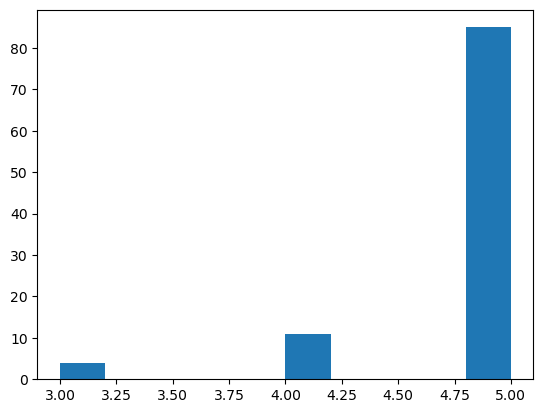

In [105]:
# Amusez-vous ici avec df_reviews
plt.hist(df_reviews['note'])

La partie scraping est à présent terminée.
La table que vous trouverez pour la seconde partie du sujet a été obtenue par scraping en itérant ce que vous avez recodé sur une liste donnée d'entreprises.

Si vous souhaitez en savoir plus sur le monde du web scraping ou si vous voulez réitérer l'expérience sur d'autres sites, n'hésitez pas à consulter les ressources mentionnées au début du sujet.

## Partie 2 : Analyse textuelle et NLP

Premier point de contact : Romain Avouac

La seconde partie du sujet consiste à analyser les données collectées. En particulier, étant donné que l'on dispose des commentaires laissés par les clients ainsi que leur note, il est intéressant de se demander dans quelle mesure il est possible de **prédire la note laissée par un client selon l'évaluation associée**. Pour ce faire, on va devoir coupler les méthodes de traitement du langage naturel (NLP) et celles d'apprentissage statistique (machine learning).

### Import des données

Commençons par importer les données sur lesquelles on va baser notre analyse. Il s'agit des mêmes données que celles obtenues en première partie du sujet, itérées sur plusieurs entreprises.

In [106]:
import pandas as pd

In [107]:
df = pd.read_parquet("https://minio.lab.sspcloud.fr/projet-funathon/2023/sujet5/diffusion/reviews_takeaway.parquet")

In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20438 entries, 0 to 20437
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   note     20438 non-null  int64         
 1   date     20438 non-null  datetime64[ns]
 2   title    20438 non-null  object        
 3   comment  20438 non-null  object        
 4   company  20438 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 798.5+ KB


In [112]:
df.sample(10)

,note,date,title,comment,company
9932,5,2021-06-17 14:08:15,Repas super,Repas facile à faire pas de prise de tête pour...,hellofresh.fr
9459,4,2021-09-20 20:05:53,Je suis a mon deuxième repas,"Je suis a mon deuxième repas, pour le moment j...",hellofresh.fr
5988,5,2022-09-04 11:49:20,C’est genial mais trop cher,C’est genial mais trop cher. Si on veux comman...,hellofresh.fr
4222,5,2022-12-10 12:06:58,Mon mari c'est mis à la cuisine,"Les repas sont très bons, goûteux, originaux. ...",hellofresh.fr
19184,5,2020-04-19 11:51:51,À continuer,J’ai fait ce choix en raison du confinement ma...,ollca.com
11200,5,2022-03-08 11:12:55,Re-Commande,Livraison impeccable - rapide et très bien emb...,auroremarket.fr
19232,5,2020-04-11 11:59:39,Excellent,"Excellent ! Fiable, rapide, très belle qualité...",ollca.com
8420,5,2022-02-19 19:43:32,Je suis contente des repas mais a la…,Je suis contente des repas mais a la livraison...,hellofresh.fr
15499,5,2020-04-10 09:29:03,Très bons produits,Très bons produits ! Livraison impeccable. Rie...,auroremarket.fr
7232,4,2022-05-23 17:03:54,Plats équilibrés,"Plats équilibrés , recettes faciles à mettre e...",hellofresh.fr


Dans ce sujet, nous nous limiterons aux reviews contenant bien un commentaire non vide, ce qui n'est pas toujours le cas ici. Vérifier le type de chaque variable, le nombre de valeurs manquantes (ou ici de chaînes de caractères vides) est de façon générale une bonne pratique lorsque l'on est face à une nouvelle base de données.

In [113]:
print(f"Nombre de reviews : {len(df)}")
df["comment"] = df["comment"].str.strip()  # Retirer les espaces en début ou fin de commentaire, pour aussi retirer les commentaires de type "  "
df = df[df["comment"] != ""]
print(f"Nombre de reviews avec un commentaire : {len(df)}")

Nombre de reviews : 20438
Nombre de reviews avec un commentaire : 18999


### Analyse descriptive

Avant de se lancer dans l'analyse textuelle à proprement parler, il est toujours préférable de commencer par une analyse descriptive très générale des données. Cela permet souvent de se faire une première idée de ce qu'elles contiennent et de réaliser des premières hypothèses sur le lien entre commentaire et note, que la modélisation viendra ensuite confirmer ou infirmer.

In [117]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

#### Les entreprises

Représentons tout d'abord la part des différentes entreprises dans notre base. On note une surreprésentation claire d'*hellofresh.fr*, et dans une moindre mesure d'*auroremarket.fr*. Dans une analyse rigoureuse de machine learning, il faut tenir compte de ce type de déséquilibre qui peut biaiser les prédictions du modèle.

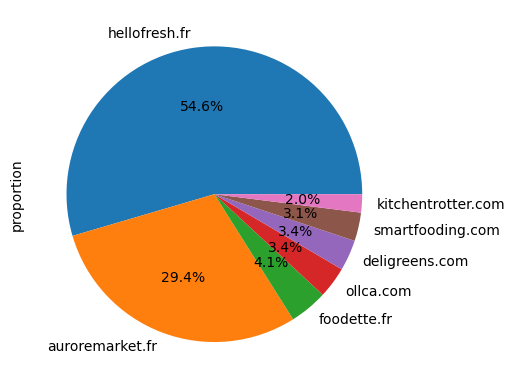

In [118]:
# Pourcentage d'avis en fonction de l'entreprise concernée
df["company"].value_counts(normalize=True).plot.pie(autopct="%.1f%%")
plt.show()

#### Les notes

Intéressons nous ensuite à la répartition des notes. Il semble qu'une large majorité d'utilisateurs soient satisfaits de leur achat (4-5). De manière intéressante, il y autant d'avis donnant la note moyenne (3) qu'une note très mauvaise (1), mais peu d'avis donnant la note 2.

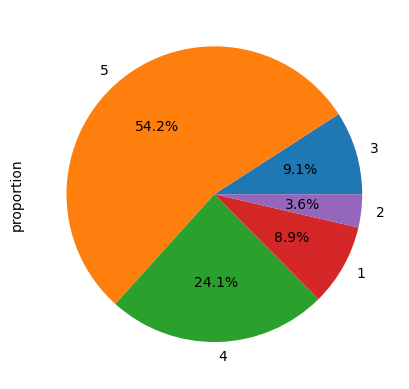

In [119]:
# Répartition des notes
df["note"].value_counts(normalize=True, sort=False).plot.pie(autopct="%.1f%%")
plt.show()

Pour réaliser le scraping, on a dû choisir les entreprises cibles et lire quelques avis afin de comprendre la structure HTML des pages. Ces premiers avis semblaient donner l'impression qu'*hellofresh.fr* était particulièrement plébiscité, là où au contraire *kitchentrotter.com* semblait très largement associé à des expériences négatives. Est-ce effectivement le cas dans les données complètes ? Pour le vérifier, on analyse la proportion des notes pour ces deux entreprises particulières. Le constat est sans appel et confirme nos premières conjectures !

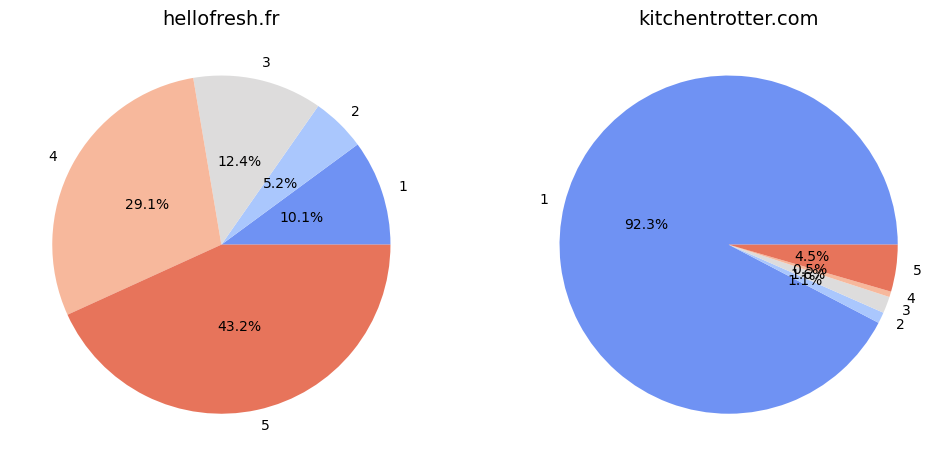

In [135]:
# Répartition des notes pour des entreprises données
plt.figure(figsize=[12,6])
colors = sns.color_palette('coolwarm', n_colors=5)

plt.subplot(121)
data = df[df['company'] == 'hellofresh.fr']["note"].value_counts(normalize=True, sort=False).sort_index()
labels = data.keys()
plt.pie(x=data, autopct="%.1f%%", labels=labels, colors = colors, pctdistance=0.5)
plt.title("hellofresh.fr", fontsize=14);

plt.subplot(122)
data = df[df['company'] == 'kitchentrotter.com']["note"].value_counts(normalize=True, sort=False).sort_index()
labels = data.keys()
plt.pie(x=data, autopct="%.1f%%", labels=labels, colors = colors, pctdistance=0.5)
plt.title("kitchentrotter.com", fontsize=14)

plt.show()

#### Les dates

A vous de jouer à présent !
Représentez le nombre d'avis scrapés sur Trustpilot __par mois__ en fonction du temps.
Y a-t-il des observations que vous pouvez faire sur cette évolution ?

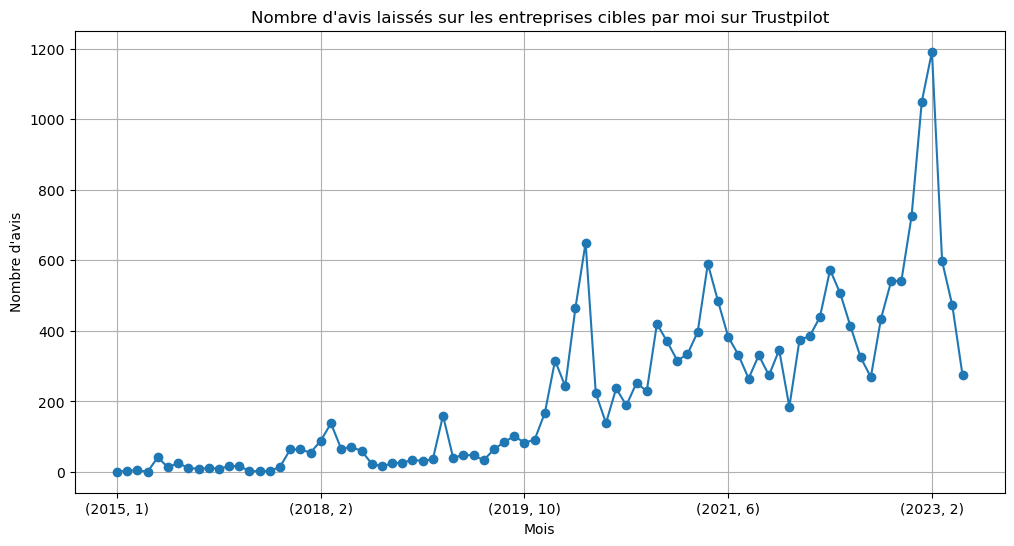

In [133]:
data = df.groupby([df.date.dt.year,df.date.dt.month]).size()

plt.figure(figsize=(12,6))
data.plot(kind="line", marker="o")
plt.xlabel("Mois")
plt.ylabel("Nombre d'avis")
plt.title("Nombre d'avis laissés sur les entreprises cibles par moi sur Trustpilot")
plt.grid(True)
plt.show()

<details>
<summary> <font size=2 color="red"><b>Dérouler pour révéler le corrigé</b></font> </summary>
<br>

```python
nb_avis_par_mois = df.groupby(pd.Grouper(key='date', freq='M')).size()

# Création du graphique
plt.figure(figsize=(12, 6))
nb_avis_par_mois.plot(kind='line', marker='o')
plt.xlabel('Mois')
plt.ylabel('Nombre d\'avis laissés')
plt.title('Nombre d\'avis laissés sur les entreprises cibles par mois sur Trustpilot')
plt.grid(True)
plt.show()
```

<br>

On peut observer que le nombre d'avis collectés n'évolue pas énormément de 2015 à 2020, puis qu'une tendance croissante émerge avec de fortes fluctuations. Un pic apparaît autour de février 2023 avant de redescendre.

</details>

Pour aller plus loin, on peut différencier le graphique précédent par entreprise pour savoir comment se comporte chacune d'elles sur le site.
Représentez donc sur un même graphe le nombre d'avis scrapés sur Trustpilot par __an__ en fonction du temps, différencié par entreprise.
Quelles conclusions pouvez-vous tirer ?

In [32]:
# TODO

plt.show()

<details>
<summary> <font size=2 color="red"><b>Dérouler pour révéler le corrigé</b></font> </summary>
<br>

```python
nb_avis_par_an_par_entreprise = df.groupby([pd.Grouper(key='date', freq='Y'), 'company']).size().unstack()

plt.figure(figsize=(12, 6))
for company in nb_avis_par_an_par_entreprise.columns:
    nb_avis_par_an_par_entreprise[company].plot(kind='line', marker='o', label=company)

plt.xlabel('Année')
plt.ylabel('Nombre d\'avis scrapés')
plt.title('Nombre d\'avis laissés par entreprise sur les entreprises cibles par mois sur Trustpilot')
plt.legend()
plt.grid(True)
plt.show()
```

<br>

On peut observer qu'Aurore Market a un pic d'activité en 2020, qui semble décroire depuis. A l'inverse, les avis sur Hellofresh se sont multipliés deouis 2020 pour atteindre un pic en 2022. On ne peut encore rien dire de 2023, puisque nous ne sommes qu'à la moitié de l'année, même si le nombre d'avis pour HelloFresh en un semestre semble déjà assez élevé.

</details>

Si vous souhaitez aller encore plus loin, vous pouvez représenter la note moyenne donnée par entreprise et par mois en fonction du temps, pour voir si la tendance des notes donnée à une entreprise est à la hausse ou à la baisse, et ainsi voir si le service s'améliore ou non par rapport à la concurrence et au passé.

#### Les commentaires

##### Longueurs

Intéressons-nous à présent au contenu des commentaires. Pour réaliser des analyses pertinentes à partir de données textuelles, il est indispensable d'utiliser les outils spécialisés du NLP, que ce soit pour nettoyer les données ou bien pour les exploiter. C'est ce que nous ferons dans les prochaines sections du tutoriel. Pour le moment, on peut d'ores et déjà s'intéresser à quelques caractéristiques très générales des textes, comme le nombre de caractères, la présence de majuscules ou de points d'exclamation, qui peuvent indiquer une certaine polarité des commentaires.

On représente d'abord le lien entre le nombre de caractères d'un commentaires et la note associée, sous forme de boîtes à moustache par note. La première représentation semble indiquer un certain gradient, mais on remarque également un grand nombre de valeurs extrêmes, symbolisées par les points. Ces valeurs extrêmes sont toujours intéressantes à analyser. Mais elles déforment l'échelle du graphique et peuvent empêcher de bien voir les écarts entre les boîtes.

<Axes: xlabel='note', ylabel='comment_length'>

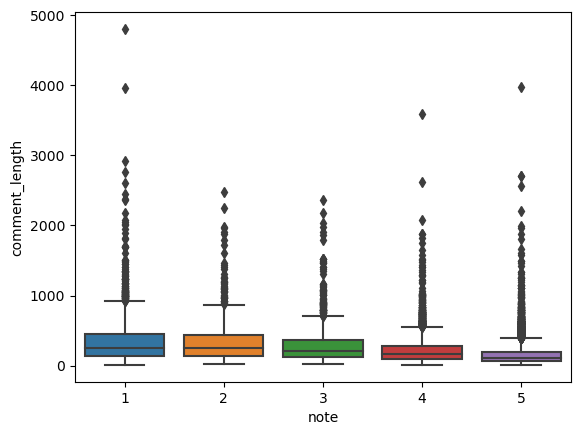

In [142]:
# Lien entre la longueur d'un commentaire et la note
df['comment_length'] = df['comment'].str.len()

sns.boxplot(x="note", y="comment_length", data=df)

Pour limiter cet effet, on s'intéresse aux commentaires de moins de 1000 caractères, soit la large majorité d'entre eux. On perçoit ainsi mieux le gradient existant entre les boîtes. Il semble à ce stade que les consommateurs insatisfaits donnent en moyenne des commentaires plus longs, et inversement, et cet effet semble assez continu avec le niveau de notes.

<Axes: xlabel='note', ylabel='comment_length'>

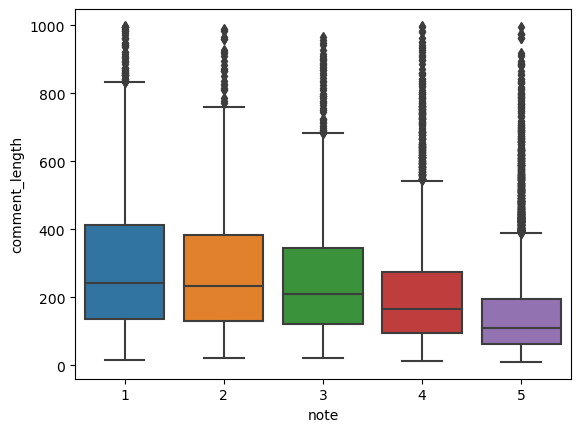

In [143]:
sns.boxplot(x="note", y="comment_length", data=df[df['comment_length'] < 1000])

##### Expressions régulières

On peut ensuite vouloir par exemple détecter des signes d'énervement, comme la présence de nombreuses majuscules ou de points d'exclamation. On pourrait faire ces calculs en Python, mais cela serait fastidieux à coder. Pour détecter la présence de caractères ou séries de caractères dans un texte (des *patterns*), on utilise une syntaxe particulière, celle des expressions régulières (*regex*).

La maîtrise des *regex* est un long voyage semé de frustration. Heureusement, on va se contenter dans ce tutoriel de motifs de base, très simples à comprendre. De plus, le site [regex101](https://regex101.com/) est très utile pour tester interactivement ses idées de regex : on y insère sa regex dans la case *REGULAR EXPRESSION* et le texte duquel on veut extraire de l'information dans la case *TEST STRING*, et l'on voit directement ce qui sera détecté (*matché*) dans le texte en question par la regex. Le site fournit par ailleurs, en bas à droite de la page, un pense-bête des principales syntaxes utilisées pour construire des regex. 

Pour utiliser des regex en `Python`, on utilise le package `re` (pas besoin de l'installer, il fait partie de la librarie standard). Ensuite, il y a à chaque fois deux étapes :
- on compile la regex que l'on souhaite utiliser via la fonction `re.compile`. Cela crée un "objet" qui modélise la regex souhaitée.
- on utilise les méthodes (fonctions associées à des objets) de l'objet pour extraire de l'information. En l'occurence, on va utiliser la méthode `findall` pour compter le nombre d'occurences du *pattern* dans le texte

Pour chaque cas, on définit une fonction qui prend en entrée un texte et retourne en sortie respectivement la proportion de majuscules et de points d'exclamation. Puis on utilise la méthode `apply` des séries `Pandas` pour appliquer ces fonctions à chacun de nos commentaires, en créant des nouvelles colonnes.

In [144]:
import re

In [145]:
# Regex pour extraire des infos du texte

def compte_majuscules(commentaire):
    r = re.compile("[A-Z]")  # Regex qui match toute majuscule
    capslock = r.findall(commentaire)  # Compte le nombre de majuscules dans le texte
    return len(capslock) / len(commentaire)  # Normalisation par la longueur du texte

def compte_points_exclamation(commentaire):
    r = re.compile("\!")  # Regex qui match tout point d'exclamation
    exclamation = r.findall(commentaire)  # Compte le nombre de points d'exclamation dans le texte
    return len(exclamation) / len(commentaire)  # Normalisation par la longueur du texte


df['part_majuscules'] = df['comment'].apply(compte_majuscules)
df['part_points_exclamation'] = df['comment'].apply(compte_points_exclamation)

In [146]:
df[["comment", "part_majuscules", "part_points_exclamation"]].head()

,comment,part_majuscules,part_points_exclamation
0,"Des produits manquants pour une recette, conta...",0.007833,0.000000
1,Les box hellofresh nous facilitent le quotidie...,0.013072,0.000000
2,Super idée recettes délicieuses. Tous les ingr...,0.014963,0.000000
3,"Jusqu’à présent satisfait de la marque, mais u...",0.015209,0.015209
4,Expérience d'achat inacceptable. Une chaîne du...,0.008715,0.006536


A présent, on va s'intéresser au lien entre la présence ou non de ces *patterns* dans les commentaires et la note donnée. Pour cela, on va utiliser des *violin plots*, du fait de leur forme en violon. L'idée est proche de la boîte à moustache, dans la mesure où l'on retrouve celle-ci et les statistiques qu'elle fournit (médiane, quartiles..) mais avec en plus un concept de **densité**, qui permet de voir rapidement la concentration des observations à certains niveaux de la distribution. Là encore, on va couper les valeurs extrêmes afin d'obtenir une échelle plus représentative de l'ensemble de la distribution.

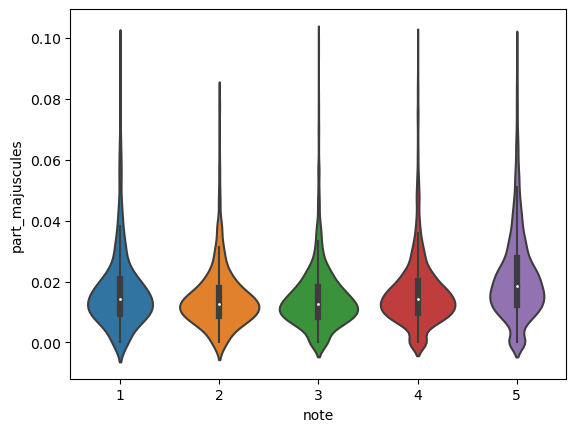

In [147]:
# Lien entre le nombre de majuscules et la note
data = df[df["part_majuscules"] < 0.1]
sns.violinplot(x="note", y="part_majuscules", data=data)
plt.show()

Le groupe des notes 5 se détache légèrement du reste, avec une part plus importante de majuscules en moyenne. Dans une moindre mesure, le groupe des notes 1 également. Le constat, s'il est difficile à établir statistiquement, n'en reste pas moins logique à première vue : les consommateurs très satisfaits et inversement très mécontents ont tendance à plus utiliser de majuscules que les autres.

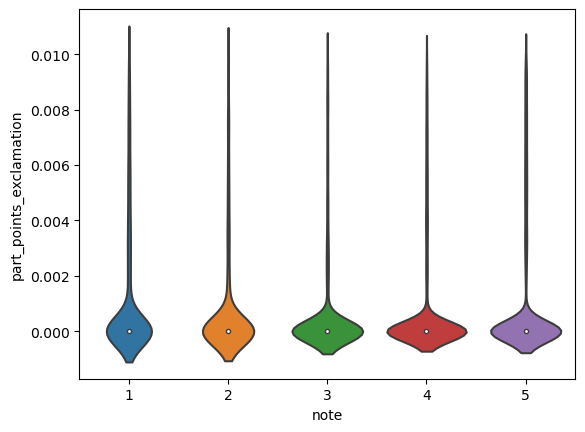

In [148]:
# Lien entre le nombre de points d'exclamation et la note
data = df[df["part_points_exclamation"] < 0.01]
sns.violinplot(x="note", y="part_points_exclamation", data=data)
plt.show()

Pour ce qui est des points d'exclamation, le constat est moins net. On aurait tendance à dire que les distributions des groupes des notes 1 et 2 sont plus étirées en longueur, ce qui pourrait indiquer une proportion un peu plus forte de points d'exclamation en moyenne.

##### A vous de jouer

Répliquez l'analyse précédente en utilisant d'autres expressions régulières que vous pensez pertinentes.
Êtes-vous capables d'obtenir une meilleure corrélation avec la note que ce qui est présenté ci-dessus ?

Quelques exemples que vous pouvez utiliser :
- Le nombre de points d'interrogation dans le commentaire
- Le nombre de points d'exclamation successifs
- La recherche de smileys, comme "^^" ou bien ":("

In [149]:
# TODO

# Regex pour extraire des infos du texte

def compte_points_interrogation(commentaire):
    r = re.compile("\?")  # Regex qui match toute majuscule
    capslock = r.findall(commentaire)  # Compte le nombre de majuscules dans le texte
    return len(capslock) / len(commentaire)  # Normalisation par la longueur du texte

def compte_points_exclamation_successif(commentaire):
    r = re.compile("!{2,}")  # Regex qui match tout point d'exclamation
    exclamation = r.findall(commentaire)  # Compte le nombre de points d'exclamation dans le texte
    return len(exclamation) / len(commentaire)  # Normalisation par la longueur du texte

def compte_smiley_joie(commentaire):
    r = re.compile("(:-|:|=|;-|;|=|:D|;-D|;D|\]|-]|\]|}|-\}|;\}|:>|;->|;>|:3|✿◠‿◠){2,}")  # Regex qui match tout point d'exclamation
    exclamation = r.findall(commentaire)  # Compte le nombre de points d'exclamation dans le texte
    return len(exclamation) / len(commentaire)  # Normalisation par la longueur du texte

def compte_smiley_triste(commentaire):
    r = re.compile("(:-|:|=|;-|;|=|:\(|:-\(|;\(|:\[|:-\[|;\[|:\{|:-\{|;\{|:\(|:-\(){2,}")  # Regex qui match tout point d'exclamation
    exclamation = r.findall(commentaire)  # Compte le nombre de points d'exclamation dans le texte
    return len(exclamation) / len(commentaire)  # Normalisation par la longueur du texte
    
df['part_points_interrogation'] = df['comment'].apply(compte_points_interrogation)
df['part_points_exclamation_successif'] = df['comment'].apply(compte_points_exclamation_successif)
df['part_points_smiley_joie'] = df['comment'].apply(compte_smiley_joie)
df['part_points_smiley_triste'] = df['comment'].apply(compte_smiley_triste)

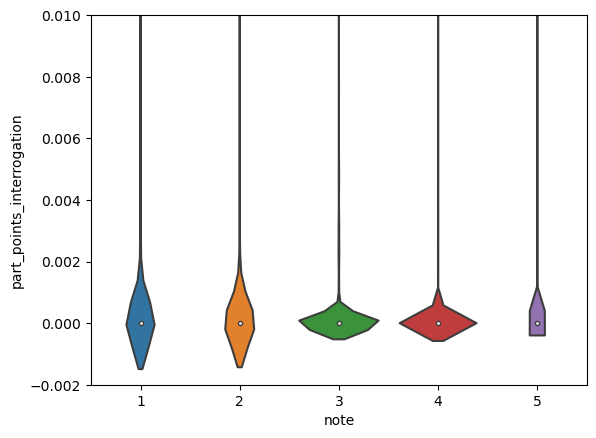

In [168]:
# Lien entre le nombre de points d'exclamation et la note
data = df[df["part_points_interrogation"] < 1]
sns.violinplot(x="note", y="part_points_interrogation", data=data)
ax = plt.gca()
ax.set_ylim(-0.002,0.01)
plt.show()

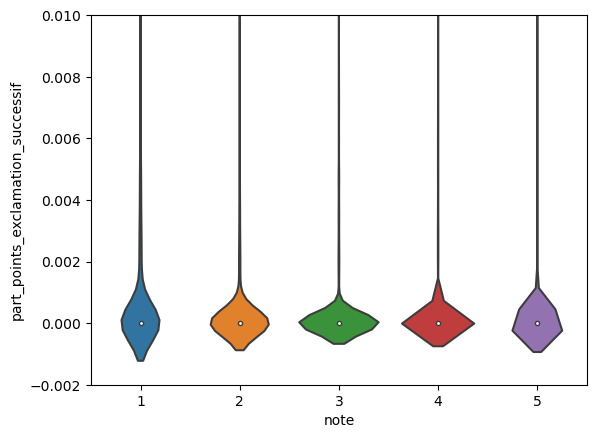

In [170]:
# Lien entre le nombre de points d'exclamation et la note
data = df[df["part_points_exclamation_successif"] < 1]
sns.violinplot(x="note", y="part_points_exclamation_successif", data=data)
ax = plt.gca()
ax.set_ylim(-0.002,0.01)
plt.show()

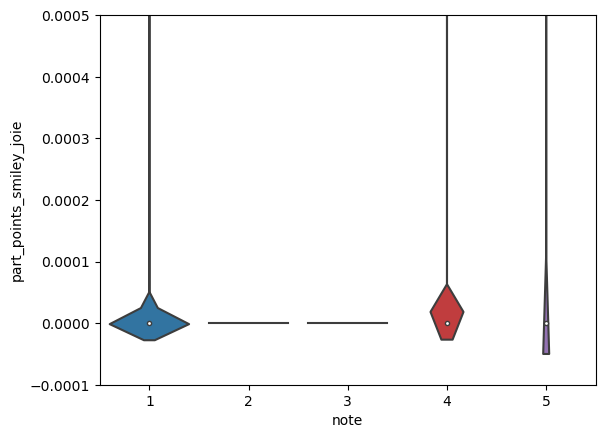

In [180]:
# Lien entre le nombre de points d'exclamation et la note
data = df[df["part_points_smiley_joie"] < 1]
sns.violinplot(x="note", y="part_points_smiley_joie", data=data)
ax = plt.gca()
ax.set_ylim(-0.0001,0.0005)
plt.show()

Globalement, on voit que ces statistiques très généralistes sur les textes ont leur utilité, mais ne sauraient suffire à les distinguer. Il va donc falloir aller plus loin et **s'intéresser aux mots utilisés par les clients et en dégager une polarité**. Mais comment extraire l'information présente dans un texte sous une forme "compréhensible" par l'ordinateur, et donc utilisable pour prédire la note associée à un commentaire selon son contenu ?

La réponse à cette question n'est pas triviale, et de nombreuses méthodes concurrentes existent. Dans ce tutoriel, on va s'intéresser aux **méthodes classique de l'analyse textuelle, qui consistent à résumer l'information présente dans un texte par la fréquence des mots qu'il contient**. L'idée est intuitive : si l'on observe que les commentaires ayant une note faible contiennent souvent le mot "manquant" et inversement les commentaires ayant une note élevée le mot "parfait", il est clair que l'on pourra utiliser cette information pour prédire la note associée à un commentaire.

### Nettoyage et prétraitements

Pour qu'une analyse fréquentielle ait du sens, il est nécessaire au préalable de bien nettoyer et pré-traiter les données textuelles. L'idée générale de cette partie est qu'il est nécessaire de *normaliser* au maximum les textes afin que les fréquences calculées soient les plus pertinentes possibles.

Les premières normalisations à effectuer sont assez naturelles :
- On va transformer tous les textes en minuscules. On utilise pour ce faire les fonctions de `Pandas`.
- On va retirer tous les accents. On utilise pour ce faire la fonction `unidecode` du package du même nom, qui va transformer tous les caractères en leur représentation [ASCII](https://fr.wikipedia.org/wiki/American_Standard_Code_for_Information_Interchange) la plus proche, une nomenclature très basique qui contient seulement les caractères essentiels.

In [181]:
from unidecode import unidecode

In [182]:
df["comment"] = df["comment"].str.lower()
df["comment"] = df["comment"].apply(unidecode)

In [183]:
df["comment"].head()

0    des produits manquants pour une recette, conta...
1    les box hellofresh nous facilitent le quotidie...
2    super idee recettes delicieuses. tous les ingr...
3    jusqu'a present satisfait de la marque, mais u...
4    experience d'achat inacceptable. une chaine du...
Name: comment, dtype: object

On va ensuite vouloir procéder à des normalisations un peu plus fines : supprimer la ponctuation, supprimer les chiffres, supprimer les mots trop fréquents, qui ne portent pas de sens mais peuvent biaiser l'analyse, etc. On pourrait essayer de faire tout ça à la main en `Python`, mais non seulement cela serait fastidieux, cela serait aussi assez compliqué en pratique : comment gère-t-on le cas d'un apostrophe ? Comment gère-t-on le cas des nombres décimaux séparés par une virgule ou un point selon les régions ? Comment définit-on un mot trop fréquent ?

Heureusement, de nombreuses personnes avant nous se sont posé ses questions, de sorte qu'il existe des outils très efficaces et bien pensés pour se faire. La librairie standard pour effectuer ce genre de traitements en `Python` s'appelle `nltk`. Dans ce tutoriel, on va plutôt présenter la librairie `spaCy`, plus moderne et souvent beaucoup plus performante lorsqu'il s'agit de traiter un large corpus de textes.

In [185]:
import spacy 

La grande force de `spaCy` est de proposer des modèles pré-entrainés pour de nombreuses langues. Très concrètement, il s'agit de modèles d'apprentissage statistique, en général entraînés via des méthodes de *deep-learning*, que l'on a entraîné à différentes tâches (ex : reconnaître les entités nommées, reconnaître la fonction grammaticale d'un mot, etc.) sur d'énormes volumes de texte. Par conséquent, ils sont capables de comprendre finement la structure du langage, et vont nous être utiles pour normaliser au maximum nos textes.

On commence donc par charger le modèle français. On prend le moyen (`md` pour *medium*), qui donne généralement des résultats satisfaisants tout en restant de taille limitée, mais notons qu'on pourrait avoir de meilleurs résultats en utilisant le modèle `lg` (*large*). Dans le cadre de ce tutoriel, le modèle a déjà été pré-téléchargé. En pratique, dans un environnement vierge, il faudrait le télécharger pour pouvoir l'utiliser avec la commande suivante :

In [45]:
# !python -m spacy download fr_core_news_md

In [186]:
nlp = spacy.load("fr_core_news_md")

L'objet `Python` que l'on récupère s'applique directement aux textes comme une fonction, et permet de faire une multitude d'actions sur ces textes. Regardons ces différentes possibilités avec un exemple simple.

In [187]:
comment = df["comment"][0]
doc = nlp(comment)

print(doc)

des produits manquants pour une recette, contact en chat, indemnise de 4,05 euros sur l appli qui ne peut pas etre utilise en meme temps qu une reduction donc sincerement autant ne rien avoir, nous n avons pas toujours le budget donc je trouve ca vraiment decevant. au final c est soit on paye le prix fort, soit avec des parrainages donc ces 4,05 nous n en profiterons jamais. decus


Jusque là rien de bien révolutionnaire : on voit que l'on peut imprimer l'objet `doc` renvoyé par le modèle lorsqu'on lui fournit un texte en entrée. Encore heureux..

Mais cet objet `doc` contient de fait tout un ensemble de caractérisations sur le texte qui vont nous être bien utiles. En particulier, il s'est chargé d'une tâche essentielle : la ***tokenisation***. Il s'agit du procédé qui consiste à convertir un texte en une série de *tokens*, i.e. de petites unités ayant une valeur sémantique. Il peut s'agir des mots, des caractères, de groupes de caractères, etc. Dans notre cas, on va vouloir faire une analyse fréquentielle à partir des termes, il fait donc sens de séparer le texte en mots.

L'objet `nlp` découpe par défaut le texte initial en *tokens*. Il suffit d'itérer sur cet objet pour passer en revue les différents *tokens*. Par ailleurs, `spaCy` détecte automatiquement un ensemble d'informations bien utiles sur les *tokens* :
- la fonction grammaticale (attribut `.tag_`)
- est-ce qu'il s'agit d'un *stop-word*, i.e. d'un mot très fréquent et donc qui ne porte généralement pas d'information pertinente (attribut `.is_stop`)
- est-ce qu'il s'agit d'un élément de ponctuation (attribut `.is_punct`)
- est-ce qu'il ne contient que des caractères alphabétiques (attribut `.is_alpha`)

Et tout un tas d'autres choses. N'hésitez pas à explorer la très complète [documentation](https://spacy.io/usage/linguistic-features) pour une vue détaillée des possibilités de `spaCy`.

In [48]:
for token in doc[:15]:
    print(token.text, token.tag_, token.is_stop, token.is_punct, token.is_alpha)

des DET True False True
produits NOUN False False True
manquants ADJ False False True
pour ADP True False True
une DET True False True
recette NOUN False False True
, PUNCT False True False
contact NOUN False False True
en ADP True False True
chat NOUN False False True
, PUNCT False True False
indemnise NOUN False False True
de ADP True False True
4,05 NUM False False False
euros NOUN False False True


En particulier, un dernier attribut va nous intéresser dans notre entreprise de normalisation des textes : la ***lemmatisation***. Cela consiste à remplacer chaque mot par sa forme neutre canonique. En effet, si l'on calcule les fréquences d'apparition des différents mots pour caractériser les textes, on voudrait par exemple que les mots "manquant", "manquants" ou encore "manquante" soient comptés comme un seul et même mot, dans la mesure où ils portent la même valeur sémantique.

In [49]:
for token in doc[:15]:
    print(token.text, token.lemma_)

des un
produits produit
manquants manquant
pour pour
une un
recette recette
, ,
contact contact
en en
chat chat
, ,
indemnise indemnise
de de
4,05 4,05
euros euro


Armé de tous ces attributs bien utiles que nous offre à peu de frais `spaCy`, on va normaliser nos textes de la manière suivante :
- suppression des *stop-words*
- suppression de la ponctuation
- suppression des mots non-alphabétiques (chiffres, etc.)
- suppression des *tokens* de trois caractères ou moins

Illustrons comment cela se fait pour un texte donné.

In [50]:
no_stop_lemma_list = []

for token in doc:
    # On rajoute un token à la liste s'il remplit les conditions suivantes
    if not (token.is_stop or token.is_punct) and token.is_alpha and len(token) >= 3:
        no_stop_lemma_list.append(token.lemma_)

# On concatène les éléments de la liste, séparés par un espace
no_stop_lemma = " ".join(no_stop_lemma_list)

print(doc)
print()
print(no_stop_lemma)

des produits manquants pour une recette, contact en chat, indemnise de 4,05 euros sur l appli qui ne peut pas etre utilise en meme temps qu une reduction donc sincerement autant ne rien avoir, nous n avons pas toujours le budget donc je trouve ca vraiment decevant. au final c est soit on paye le prix fort, soit avec des parrainages donc ces 4,05 nous n en profiterons jamais. decus

produit manquant recette contact chat indemnise euro appli utiliser temps reduction sincerement autant rien budget trouver vraiment decever final payer prix fort parrainage profiter jamais decu


Pas mal ! Maintenant on voudrait bien appliquer cela à tous les textes de notre corpus. En réalité, même si cela ne s'est pas vu sur un seul document, ce processus est assez coûteux en temps. Heureusement, `spaCy` nous permet de largement l'accélérer :
- on va paralléliser les calculs, de sorte que 5 textes vont être normalisés en parallèle
- on va supprimer les fonctions de `spaCy` dont on ne va pas se servir en pratique

In [188]:
pipe = nlp.pipe(df["comment"], n_process=5,
                disable=["tagger", "parser", "attribute_ruler", "ner"])

Une fois l'objet `pipe` défini, on peut itérer sur les commentaires par une simple boucle. On va construire notre processus étage par étage :
- une fonction `preprocess_token` qui prend un *token* en entrée, retourne sa version lématisée si jamais il respecte les conditions énoncées précédemment, et une chaîne de caractères vide sinon
- une fonction `preprocess_text` qui prend en entrée un texte au format objet `spaCy` (i.e. un élément de l'objet `pipe`), qui applique à chaque *token* la fonction `preprocess_token` en supprimant au passage les *tokens* vides, et renvoie le texte normalisé sous la forme d'une seule chaîne de caractères

Il nous suffit ensuite d'appliquer la fonction `preprocess_text` à chaque élément de l'objet `pipe`, i.e. chaque commentaire, pour obtenir la liste des textes normalisés. Cette opération ne devrait pas prendre plus d'une minute.

In [194]:
def preprocess_token(token):
    if not (token.is_stop or token.is_punct) and token.is_alpha and len(token) >= 3:
        return token.lemma_
    else:
        return ""

def preprocess_text(text_nlp):
    text_pretraite_list = [preprocess_token(token) for token in text_nlp if token]
    text_pretraite = " ".join(text_pretraite_list)
    return text_pretraite

commentaires_pretraites = [preprocess_text(commentaire) for commentaire in pipe]

Finalement, on peut rajouter à notre dataset la version normalisée des commentaires, et vérifier que les résultats font effectivement sens.

In [195]:
df["comment_pretraite"] = commentaires_pretraites
df[["title", "comment", "comment_pretraite"]].head()

,title,comment,comment_pretraite
0,Des produits manquants pour une…,"des produits manquants pour une recette, conta...",produit manquant recette contact chat in...
1,Facile et pratique,les box hellofresh nous facilitent le quotidie...,box hellofresh faciliter quotidien pense...
2,Super idée recettes délicieuses.,super idee recettes delicieuses. tous les ingr...,super idee recette delicieuse ingredient f...
3,Service de livraison incompétent !,"jusqu'a present satisfait de la marque, mais u...",present satisfait marque service livra...
4,Expérience d'achat inacceptable,experience d'achat inacceptable. une chaine du...,experience achat inacceptable chaine froid...


### Analyse textuelle des commentaires

#### Nuages de mots

Petit exercice en marge de la suite : maintenant les commentaires nettoyés et les stopwords retirés, il est possible de générer une visualisation intéressante supplémentaire : les __nuages de mots__. Il s'agit d'une représentation des mots les plus représentés dans notre base de commentaires, dont les tailles grandissent avec leur volume dans le corpus.

Exécutez les cellules ci-dessous pour comprendre comment cela fonctionne :

In [192]:
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

In [196]:
corpus_cleaned_comments = ' '.join(df['comment_pretraite'])  # Concaténer tout le corpus en une chaîne de caractères
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(corpus_cleaned_comments)  # Créer le nuage de mots

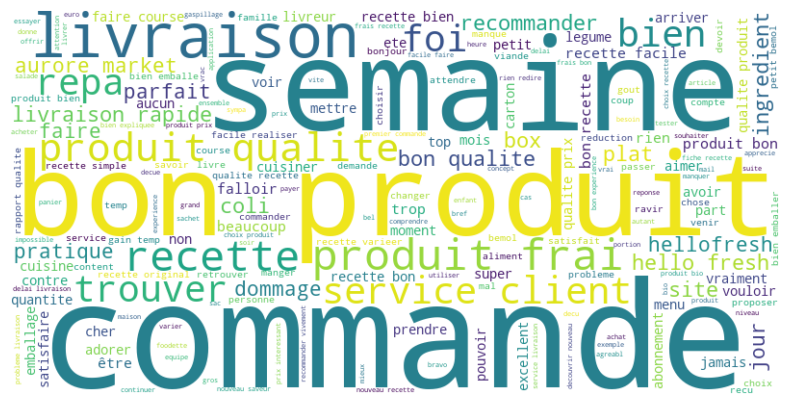

In [197]:
# Afficher le nuage de mots
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

__Exercice__ : A vous de jouer maintenant, en vous inspirant du code ci-dessus, créez un nuage de mots par entreprise pour toutes les entreprises présentes dans la base de données. Voyez-vous des différences significatives entre les nuages de mots des unes et des autres ? Comparez notamment le nuage de mots de Hellofresh et de KitchenTrotter.

In [57]:
# TODO


#### Vectorisation

A présent, nos textes sont relativement normalisés, ce qui va nous permettre d'effectuer une analyse fréquentielle digne de ce nom. La prochaine étape va consister à transformer notre information textuelle en une information numérique, compréhensible par des machines et donc exploitable dans une analyse statistique. Cette étape s'appelle la **vectorisation** : on va transformer une liste de *tokens* en un vecteur numérique. Il existe de nombreuses méthodes permettant de vectoriser un texte, avec plus ou moins de complexité.

Commençons par détailler la plus intuitive : la **vectorisation par comptage**. Cette méthode consiste simplement à représenter chaque texte par un vecteur qui pour chaque mot du vocabulaire indique la fréquence du mot dans le texte. L'exemple ci-dessous illustre ce procédé pour un texte.

![](img/countvectorizer.png)

Bien sûr, l'idée est d'appliquer cette opération non pas à un seul texte mais à tous les textes de notre corpus. Il faut pour cela que les vecteurs de comptage soient comparables. On va donc procéder en plusieurs étapes :
- récupérer le vocabulaire complet du corpus, i.e. tous les tokens uniques présents dans les textes du corpus
- les classer par ordre alphabétique
- représenter chaque texte par un vecteur de fréquence au sein du vocabulaire complet. Ainsi, la matrice qui va représenter le corpus complet va être dite creuse (*sparse*), car chaque texte ne contient que quelques mots du vocabulaire complet.

Là encore, on pourrait faire tout ça en `Python`, mais ça serait pénible et sûrement inefficient. Heureusement, le package `scikit-learn`, référence pour le *machine learning* en `Python`, nous permet de faire ça très rapidement en quelques lignes de code.

In [58]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

En pratique :
- on instancie un objet de type `CountVectorizer`
- on l'"entraîne" (*fit*) sur notre corpus, ce qui a pour effet de récupérer le vocabulaire complet et de le classer par ordre alphabétique
- on vectorise nos textes (*transform*) pour construire la matrice représentant le corpus

In [59]:
texts = df["comment_pretraite"]

vectorizer = CountVectorizer()
vectorizer.fit(texts)

vocab = vectorizer.get_feature_names_out()

print(vocab[:20])

['aaaaaaaaaaaaahhhhhhhhhhhhhhhhhhhhhhhhhahhhhahhaaaaaaaahhhhhhhhh'
 'aaaaaaaaahhhhhhhhhhhhhhhhhharretez' 'aaaadddddoooorrrrreeeee'
 'aafamille' 'aarnaque' 'aarticle' 'abandonnee' 'abandonner' 'abbonne'
 'aberent' 'aberrant' 'aberration' 'aberrationune' 'abime' 'abimee'
 'abimeedommage' 'abimees' 'abiment' 'abimer' 'abimesfromage']


In [60]:
texts_vectorized = vectorizer.transform(texts)
texts_vectorized

<18999x12320 sparse matrix of type '<class 'numpy.int64'>'
	with 274848 stored elements in Compressed Sparse Row format>

In [61]:
# Exercice : à quoi correspondent les dimensions de la matrice ?

print(f"Nombre de documents dans le corpus : {len(df)}")
print(f"Taille du vocabulaire : {len(vocab)}")

Nombre de documents dans le corpus : 18999
Taille du vocabulaire : 12320


Comme notre matrice est largement creuse, `scikit-learn` la stocke au format `sparse matrix`, qui permet de prendre beaucoup moins de place en mémoire que si l'on avait stocké les "0" en dur. Dans notre cas, comme le corpus est de taille raisonnable, on peut la récupérer sous forme d'un `array NumPy` sans trop de problème, ce qui facilitera les manipulations par la suite.

In [62]:
texts_vectorized = texts_vectorized.toarray()

In [63]:
texts_vectorized

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

Le fait d'avoir vectorisé notre corpus de la sorte va maintenant nous permettre de réaliser une analyse statistique agrégée avec là encore peu de code. Commençons par afficher les mots les plus fréquents de notre corpus. Pour cela, à vous de jouer :
- Sommez la matrice par colonne afin d'obtenir la fréquence de chaque mot dans le corpus complet
- Associez dans une liste chaque mot à sa fréquence totale
- Classez les mots par fréquence totale décroissante
- Insérez les résultats dans un `DataFrame Pandas`

In [64]:
comptages_voc = pd.DataFrame(
    {'mot': ["exemple"],
     'frequence': [1]}
)  # TODO

comptages_voc.head()

,mot,frequence
0,exemple,1


<details>
<summary> <font size=2 color="red"><b>Dérouler pour révéler le corrigé</b></font> </summary>
<br>

```python
comptages = texts_vectorized.sum(axis=0)
comptages_voc = list(zip(vocab, comptages))
comptages_voc = sorted(comptages_voc, key=lambda x: x[1], reverse=True)
comptages_voc = pd.DataFrame(comptages_voc, columns=['mot', 'frequence'])
comptages_voc.head()
```

<br>

Si une ou plusieurs de ces étapes ne sont pas claires, n'hésitez pas à aller lire la documentation des fonctions correspondantes pour mieux comprendre leur fonctionnement.
</details>

On peut alors représenter très simplement les fréquences des n premiers mots du corpus :

<Axes: xlabel='frequence', ylabel='mot'>

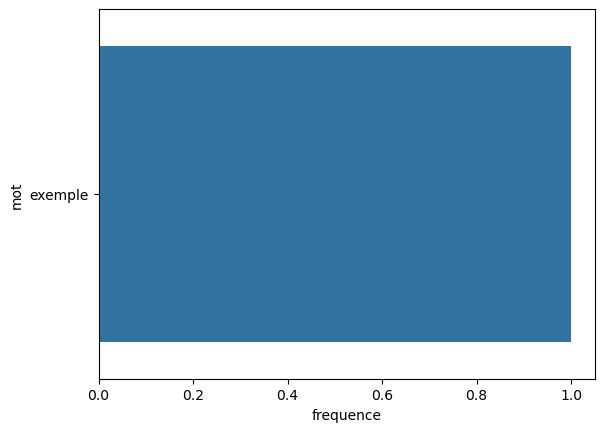

In [65]:
sns.barplot(x="frequence", y="mot", data=comptages_voc.head(10))

Si votre fonction est bien codée (ou que vous reprenez le corrigé), alors à première vue, les résultats semblent cohérents. Notons que c'est bien parce que l'on a décidé d'enlever les *stop-words* qu'on retrouve les mots qu'on attendait dans ce graphique. Sinon, il est très probable que l'on aurait eu en premier "de", "à", "le", etc. et que l'analyse n'aurait donc produit aucun résultat intéressant.

Notons également que la vectorisation telle que nous l'avons effectué ne tient aucun compte de l'ordre des mots dans la phrase, de la grammaire, etc. On dit qu'il s'agit d'une approche ***bag-of-words*** : le texte est vu comme un sac de mots, dont l'ordre n'importe pas, seules leurs fréquences dans le texte.

#### n-grammes

Tenir compte de l'ordre des mots dans la vectorisation implique tout de suite beaucoup plus de complexité dans l'analyse. Une manière relativement simple de tenir - un peu - compte de cet ordre est de s'intéresser aussi aux ***n-grammes***, i.e. aux suites de mots consécutifs. On peut s'intéresser aux bigrammes, i.e. aux suites de deux mots consécutif, aux trigrammes, etc. Mais attention : plus l'on inclut de n-grammes, plus le vocabulaire grandit rapidement, et plus l'analyse sera coûteuse en temps et en mémoire.

**Exercice** : en s'inspirant du code précédent et de la [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) du `CountVectorizer` de `scikit-learn`, créer une fonction `plot_freq_n_grammes` qui :
- applique le `CountVectorizer` aux textes pour un range de n-grammes donné (paramètre de la fonction)
- construit le `DataFrame` des comptages (cf. ci-dessus)
- renvoie les n premières lignes du `DataFrame` (paramètre de la fonction)

In [66]:
def plot_freq_n_grammes(commentaires, ngram_range=(1,1), n_results=10):
    
    comptages_voc = pd.DataFrame(columns=['mot', 'frequence'])  # TODO  
    
    return comptages_voc.head(n_results)

<font size=2 color="red"><b>Corrigé :</b></font>

In [67]:
def plot_freq_n_grammes(commentaires, ngram_range=(1,1), n_results=10):
    vectorizer = CountVectorizer(ngram_range=ngram_range)
    vectorizer.fit(commentaires)
    vocab = vectorizer.get_feature_names_out()
    
    comptages = np.array(vectorizer.transform(commentaires).sum(0))[0]
    comptages_voc = list(zip(vocab, comptages))
    comptages_voc = sorted(comptages_voc, key=lambda x: x[1], reverse=True)
    comptages_voc = pd.DataFrame(comptages_voc, columns=['mot', 'frequence'])  
    
    return comptages_voc.head(n_results)

Vérifier tout d'abord que la fonction fonctionne dans le cas des mots simples, i.e. des unigrammes. Le code suivant devrait produire le même graphique que celui ci-dessus.

<Axes: xlabel='frequence', ylabel='mot'>

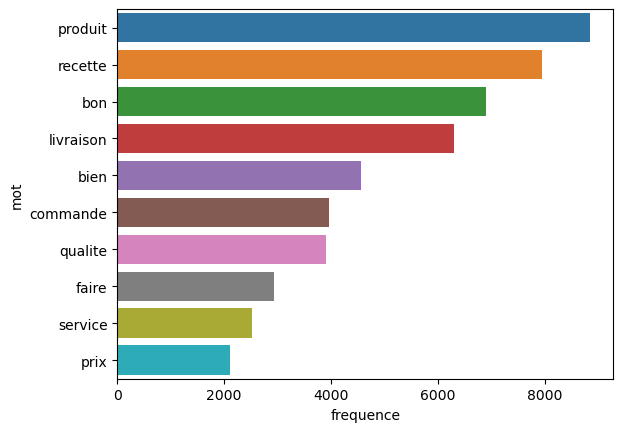

In [68]:
comptages_1_1 = plot_freq_n_grammes(commentaires=texts, 
                                    ngram_range=(1,1), 
                                    n_results=10)

sns.barplot(x="frequence", y="mot", data=comptages_1_1)

Maintenant que l'on dispose d'une fonction, il est très facile de faire varier l'étendue des *n-grammes* et de produire les mêmes graphiques.

<Axes: xlabel='frequence', ylabel='mot'>

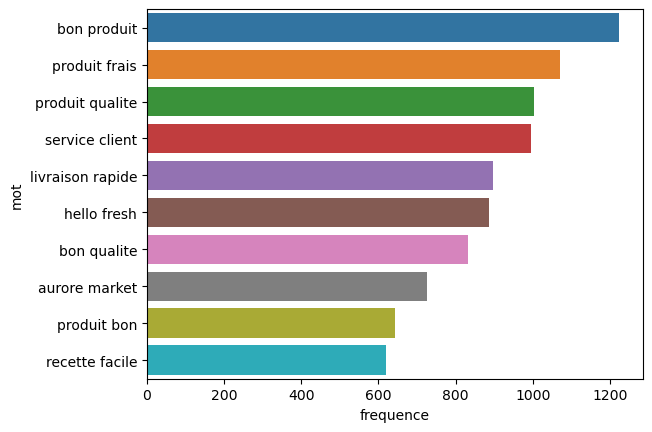

In [69]:
comptages_2_2 = plot_freq_n_grammes(commentaires=texts, 
                                    ngram_range=(2,2), 
                                    n_results=10)

sns.barplot(x="frequence", y="mot", data=comptages_2_2)

<Axes: xlabel='frequence', ylabel='mot'>

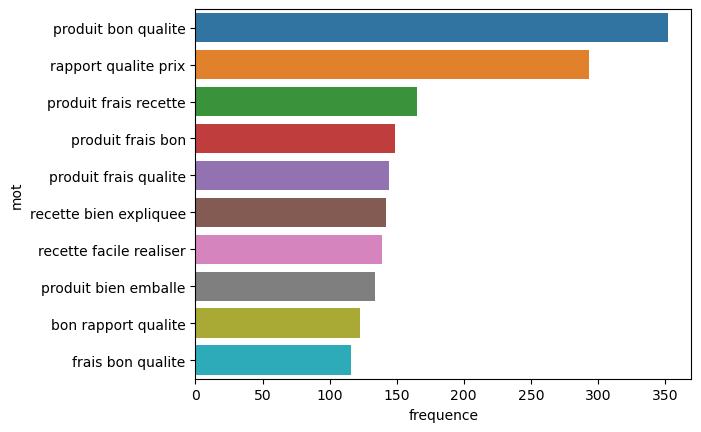

In [70]:
comptages_3_3 = plot_freq_n_grammes(commentaires=texts, 
                                    ngram_range=(3,3), 
                                    n_results=10)

sns.barplot(x="frequence", y="mot", data=comptages_3_3)

__Exercice__ : Réaliser les mêmes visualisations en restreignant les données en entrée aux commentaires avec une note de 1 (puis ceux avec une note de 5, etc.) et voir dans quelle mesure le top 10 des mots les plus fréquent change et si c'est pertinent

In [71]:
# TODO

<font size=2 color="red"><b>Corrigés :</b></font>

<Axes: xlabel='frequence', ylabel='mot'>

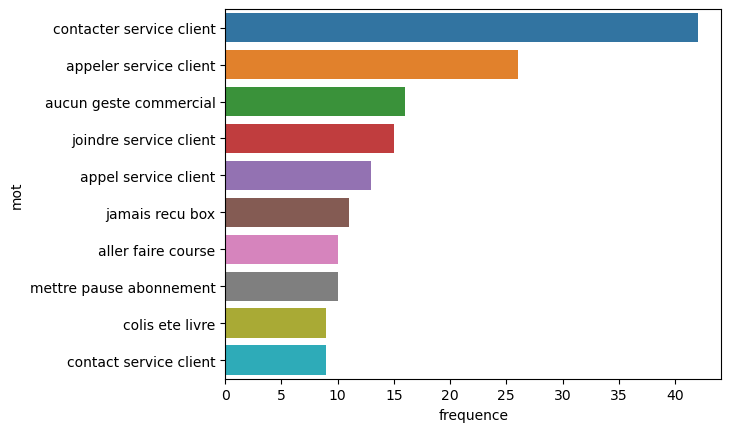

In [72]:
texts = df[df["note"] == 1]["comment_pretraite"]

comptages_3_3 = plot_freq_n_grammes(commentaires=texts, 
                                    ngram_range=(3,3), 
                                    n_results=10)

sns.barplot(x="frequence", y="mot", data=comptages_3_3)

<Axes: xlabel='frequence', ylabel='mot'>

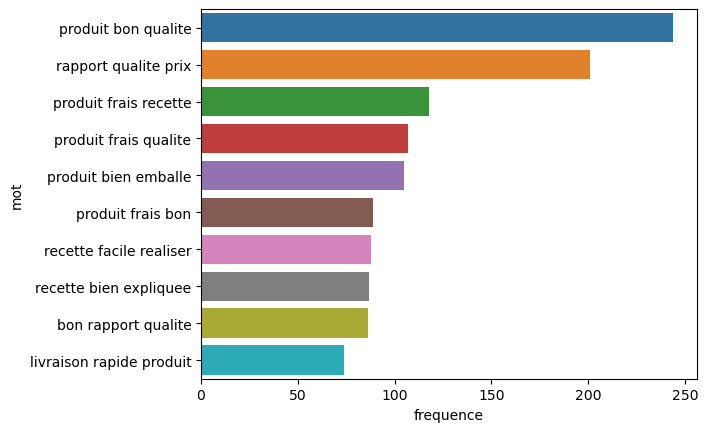

In [73]:
texts = df[df["note"] == 5]["comment_pretraite"]

comptages_3_3 = plot_freq_n_grammes(commentaires=texts, 
                                    ngram_range=(3,3), 
                                    n_results=10)

sns.barplot(x="frequence", y="mot", data=comptages_3_3)

### Apprentissage supervisé : prédiction de la note à partir du texte

Les analyses descriptives de la partie précédente nous ont bien montré que l'analyse fréquentielle semblait pertinente, dans la mesure où certains mots ou groupes de mots se retrouvaient prédominants respectivement dans les groupes de notes très basses ou très hautes. Dans cette partie, nous allons aller encore un cran plus loin, et nous demander dans quelle mesure il est possible de prédire la note associée à un commentaire, seulement à partir des mots contenus dans ce dernier. 

Etant donné qu'il s'agit d'une tache de prédiction, on va utiliser les outils du machine learning. En pratique, on va entraîner un modèle, i.e. fournir de nombreux exemples (note, commentaire) issus de notre corpus au modèle, de sorte à ce qu'il apprenne la relation entre les mots présents et la note donnée, et qu'il puisse ensuite prédire sur de nouveaux exemples (sans note).

En machine learning, on commence toujours par séparer les donnéees d'entraînement (comme expliqué ci-dessus) et les données de test, c'est à dire des données qui n'auront pas directement servi à l'entraînement et que l'on pourra donc utiliser pour évaluer rigoureusement la performance de notre modèle. Il est d'usage de garder 20% des données comme jeu de test.

In [74]:
from sklearn.model_selection import train_test_split

In [75]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=0)

In [76]:
y_train = df_train["note"]
y_test = df_test["note"]

In [77]:
print(df_train.shape, df_test.shape)

(15199, 9) (3800, 9)


#### Vectorisation par comptage

Un modèle de machine learning prend en entrée des données au format numérique. Là encore, nous allons nous baser sur l'analyse fréquentielle, i.e. vectoriser nos commentaires de manière à pouvoir les passer au modèle. Une première approche est celle que nous avons vu dans l'analyse descriptive ci-dessus, dite de vectorisation par comptage. 

In [78]:
from sklearn.feature_extraction.text import CountVectorizer

L'analyse descriptive a montré que les bigrammes et les trigrammes avaient leur pertinence. On avait donc appliquer un `CountVectorizer` avec un range de n-grammes allant de 1 à 3 inclus. On l'entraîne (*fit*) sur les données d'entraînement. Sur les données de test, on ne fait que transformer, i.e. vectoriser sous forme d'une matrice ```(n_documents, longueur_vocab)```.

In [79]:
vectorizer = CountVectorizer(ngram_range=(1,3))

X_train = vectorizer.fit_transform(df_train["comment_pretraite"])
X_test = vectorizer.transform(df_test["comment_pretraite"])

voc = vectorizer.vocabulary_
print('Taille du vocabulaire : ', len(voc))

Taille du vocabulaire :  307757


A partir de cette matrice, on va pouvoir entraîner un modèle à prédire la note associée à un texte. Par simplicité, on va assimiler la tâche de prédiction à une tâche de régression, i.e. que le modèle va devoir prédire une note continue et être le plus proche possible de la note entre 1 et 5 initiale. Pour ce qui est du modèle, on va utiliser un modèle de machine à vecteur de support (SVM) linéaire, car ceux-ci sont connus pour être efficaces sur de telles tâches de NLP. Le fonctionnement du SVM n'est pas nécessaire à la compréhension de ce que l'on essaie de faire : retenons simplement que le modèle va apprendre les liens entre fréquences des mots dans les commentaires et la note associée au commentaire, pour pouvoir ensuite prédire une note à partir d'un commentaire seul.

In [80]:
from sklearn.svm import LinearSVR

In [81]:
svr = LinearSVR(max_iter=10000)

svr.fit(X_train, y_train)  # Entraînement

LinearSVR(max_iter=10000)

Une fois le modèle entraîné, on peut l'utiliser pour prédire une note à partir d'un commentaire. On prédit donc des notes pour les données de test, ce qui va nous permettre de comparer la note prédite et la note réelle, et donc d'évaluer la qualité des prédictions. On utilise pour cela une métrique standard pour les tâches de régression : l'erreur moyenne quadratique. Là encore, la définition exacte de cette métrique n'est pas nécessaire à la compréhension de ce tutoriel, elle va simplement de nous permettre de comparer les performances de différentes modélisations.

In [82]:
from sklearn.metrics import mean_squared_error

In [83]:
y_pred = svr.predict(X_test)
y_pred

array([2.35560621, 3.67342686, 5.23864632, ..., 4.95691332, 4.64849456,
       4.75257654])

In [84]:
mean_squared_error(y_pred, y_test)

1.0721654832005743

__Exercice__ : Quelle est l'erreur moyenne absolue (MAE) associée à notre modèle ? Comment l'interpréter ?

In [85]:
# TODO

L'analyse quantitative donne une métrique qui résume les performances globales. Mais on peut également se demander pour quels groupes de notes le modèle obtient les meilleurs performances, ou bien au contraire quels groupes il ne parvient pas à distinguer. Pour cela, une analyse qualitative est nécessaire. On va simplement mettre en correspondant les notes prédites et les notes réelles sous forme de *violin plots* par groupe.

<Axes: xlabel='note', ylabel='note_predite'>

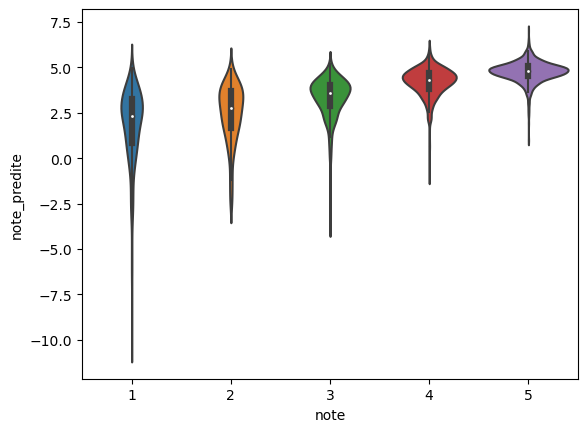

In [86]:
# Analyse qualitative
data = pd.DataFrame({'note': y_test, 'note_predite': y_pred})

sns.violinplot(x="note", y="note_predite", data=data)

Comme le SVM effectue une prédiction continue de la note, celle-ci n'est pas bornée entre 1 et 5 en toute rigueur. En pratique, on voit qu'il parvient à concentrer les notes prédites dans cette intervalle la plupart du temps, mais qu'il effectue parfois des prédictions totalement en dehors qui déforment l'échelle du graphique. Là encore, on se restreint donc aux valeurs les plus fréquentes.

<Axes: xlabel='note', ylabel='note_predite'>

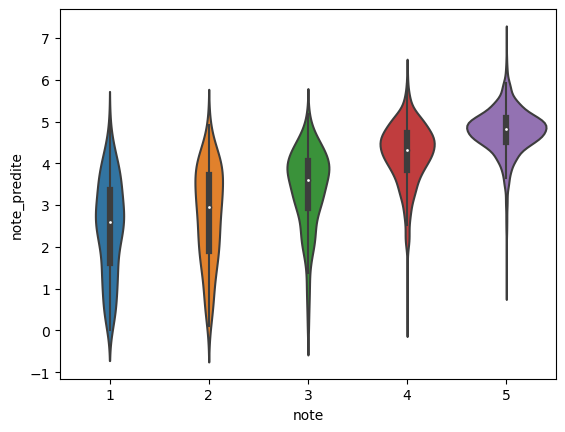

In [87]:
sns.violinplot(x="note", y="note_predite", data=data[data["note_predite"] > 0])

A première vue, ce n'est pas si mal ! On observe bien un gradient assez continu au fil des classes de notes, ce qui indique que le modèle parvient à distinguer en général les classes de commentaires. On voit cependant que cette performance n'est pas homogène selon les classes : là où les classes de note 4 et 5 sont très bien prédites, les classes inférieures et en particulier 1 et 2 sont assez difficiles à distinguer, avec une distribution des notes très continue et non "piquée" sur la note de la classe, comme on aurait aimé le voir.

Naturellement, on se demande comment on pourrait faire mieux. En NLP, c'est toujours une question compliquée car les facteurs qui contribuent à la performance sont multiples. On pourrait ainsi :
- essayer d'améliorer la qualité du pré-traitement du texte (nettoyage, normalisation..)
- essayer d'améliorer la qualité de la vectorisation en utilisant d'autres méthodes plus avancées que le simple comptage
- essayer d'utilliser d'autres modèles que le SVM pour la prédiction
- essayer de *fine-tuner* le modèle de prédiction

Dans ce tutoriel, nous allons nous concentrer sur la vectorisation, car c'est ce qui présente le plus d'intérêt du point de vue du traitement du langage.

#### Approche TF-IDF

La vectorisation par simples comptages produit déjà des résultats intéressants, mais reste assez rustre : on représente un texte par le vecteur des fréquences des termes qui le composent. Mais le fait qu'un terme apparaisse fréquemment dans un texte ne suffit pas à lui attribuer de l'importance : si le terme est par ailleurs très fréquent dans le corpus de textes complet, le fait qu'il soit fréquent dans un texte donné n'est pas très intéressant. Pour pallier cette limite, on va modifier la manière de vectoriser en repondérant les fréquences de sorte à donner plus de poids à un terme qui apparaît dans un texte donné, mais qui est par ailleurs rare dans le corpus. Ce sont en effet de tels termes qui ont a priori le plus de chance d'être discriminants pour le modèle d'apprentissage.

Cette repondération a un nom : __TF-IDF__. Vous en avez sans doute déjà entendu parler et pour cause : ce modèle a longtemps été utilisé par Google pour affiner les résultats des recherches ! Formellement, le modèle est le suivant :

![](img/tfidf.png)

Source : [http://notanotherdatafact.com](http://notanotherdatafact.com/index.php/2020/09/02/tf-idf-un-jour-tf-idf-toujours/)

Comment implémenter cette nouvelle méthode de vectorisation ? Grâce à l'incroyable qualité de la standardisation des objects du package `scikit-learn`, la procédure revient exactement au même ! Il va suffire de changer le *vectorizer* et tout le reste va suivre immédiatement. Pas mal, non ?

__Exercice__ : Reproduire l'analyse précédente en utilisant un vectorizer TF-IDF au lieu du CountVectorizer. Vous pouvez vous aider de la documentation de sklearn.

In [88]:
# TODO

<details>
<summary> <font size=2 color="red"><b>Dérouler pour révéler le corrigé</b></font> </summary>
<br>

```python
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,3))
```

<br>

Pour le reste, les cellules de code ne changent pas.

</details>

Si vous ne vous êtes pas trompés, le verdict est clair : la vectorisation TF-IDF améliore considérablement les performances, que ce soit sur le plan quantitatif ou qualitatif. Les classes 4 et 5 sont toujours aussi bien distinguées, mais surtout les classes 1, 2 et 3 sont désormais bien mieux distinguées par le modèle.

#### Exercices

Quelles sont les conclusions que vous pouvez apporter sur les différences de performances entre les deux approches ?

Avancé :
- Essayez d'autres modèles de ```scikit-learn``` que le SVM (par exemple un RandomForestRegressor) et comparez les performances obtenues
- Rajoutez des régresseurs à l'approche TF-IDF et voyez si les performances augmentent. Quelques exemples de régresseurs possibles :
  - Longueur du commentaire
  - Indicatrice de l'entreprise dont vient le commentaire
  - Indicatrice de l'année du commentaire pour tenir compte de l'évolution des marques
  - Proportion de points d'exclamation
  - Proportion de majuscules
  - ...
- Répliquez les analyses précédentes sur la colonne "Titre" plutôt que celle des commentaires. Comment évolulent les résultats ?
  - Quid de répliquer le travail sur une colonne concaténée "Titre" + "Commentaire" lorsque le titre n'est pas inclus dans le commentaire ? Les résultats sont-ils significativement améliorés ?
 
Avec ces différents suppléments, quelles sont les performances maximales que vous parvenez à atteindre ?

In [89]:
# TODO

### Apprentissage non-supervisé : détection de sujets

Les tâches de prédiction sur lesquelles nous nous sommes concentré correspondent à de l'apprentissage supervisé : chaque commentaire est associé à une note, que l'on peut aussi appeler _label_ et que l'on cherche à prédire.
Une autre branche du machine learning existe et permet de travailler sur des données non labellisées, par exemple pour faire du clustering ou des nuages de mots.

Ici, nous allons faire de l'apprentissage non supervisé pour faire de la détection des sujets principaux sous-latents à nos commentaires.

Pour ce faire, nous allons utiliser une méthode appelée LDA (Allocation de Dirichlet Latente), qui est en fait à un modèle génératif probabiliste permettant d'extraire automatiquement les sujets sous-jacents d'un corpus de documents.
L'idée principale derrière la LDA est que chaque document peut être considéré comme une combinaison de sujets, et chaque sujet est une distribution de mots.
Via une approche probabiliste, la LDA permet ainsi de découvrir les structures et les thèmes latents présents dans un corpus de documents, ce qui est particulièrement utile pour l'analyse de textes, la catégorisation de documents et l'exploration de données non structurées.

In [90]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis.lda_model

In [91]:
vectorizer = CountVectorizer(min_df=5, max_df=0.9, ngram_range=(1,3))
freq_matrix = vectorizer.fit_transform(df["comment_pretraite"])

In [92]:
lda = LatentDirichletAllocation(n_components=20, random_state=0)
lda.fit(freq_matrix)

LatentDirichletAllocation(n_components=20, random_state=0)

LDAvis est une bibliothèque de visualisation conçue spécifiquement pour explorer et interpréter les résultats d'une analyse de LDA.
Cette bibliothèque facilite la compréhension des structures de sujets identifiées par LDA en fournissant des visualisations interactives et informatives.

L'un des paramètres importants de LDAvis est le paramètre d'arbitrage fréquence/salience. Ce paramètre permet de contrôler l'affichage des mots associés à chaque sujet dans la visualisation.
La fréquence d'un terme représente le nombre d'occurrences du terme dans le corpus, tandis que la salience mesure l'importance relative d'un terme pour un sujet donné.
En ajustant ce paramètre, vous pouvez choisir de mettre davantage l'accent sur les termes les plus fréquents ou sur ceux qui sont plus saillants pour chaque sujet.
L'arbitrage fréquence/salience peut être utile pour mieux comprendre les sujets dominants et les termes clés associés à ces sujets.
Si vous souhaitez identifier les termes les plus courants et les plus représentatifs d'un sujet, vous pouvez privilégier la fréquence.
A l'inverse, si vous souhaitez mettre en évidence les termes distinctifs et significatifs qui différencient un sujet des autres, vous pouvez privilégier la salience.

Exécutez la cellule ci-dessous pour voir à quoi ressemble la visualisation offerte par ```pyLDAvis```. Le paramètre λ modifiable en haut à droite de la fenêtre interactive correspond à l'arbitrage fréquence/salience.

In [93]:
pyLDAvis.enable_notebook()
pyLDAvis.lda_model.prepare(lda, freq_matrix, vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.012582 -0.270788       1        1  11.998930
5      0.247578  0.066023       2        1   9.282950
11     0.180873  0.165953       3        1   8.374868
10     0.118028 -0.105034       4        1   6.528174
1      0.078170 -0.202643       5        1   6.186998
14    -0.214048 -0.161208       6        1   5.796072
17    -0.165382  0.215121       7        1   5.442388
8     -0.250003  0.076601       8        1   5.085835
12    -0.065606 -0.013701       9        1   5.002572
19     0.180917 -0.004975      10        1   4.230446
16     0.134694 -0.063382      11        1   4.154233
13    -0.065315  0.078232      12        1   3.756255
3     -0.182467  0.099161      13        1   3.608498
2      0.027727 -0.068464      14        1   3.471463
15    -0.102034 -0.142892      15        1   3.344737
4      0.157123  0.076894      16        1   3.084476
0     -0.030949  0.110391      17        1   2.906735
6      0.081119  0.108750      18        1   2.726131
9     -0.117039 -0.087956      19        1   2.711577
18    -0.025970  0.123916      20        1   2.306660, topic_info=            Term         Freq        Total Category  logprob  loglift
8660     produit  8529.000000  8529.000000  Default  30.0000  30.0000
9636     recette  7672.000000  7672.000000  Default  29.0000  29.0000
1230         bon  6662.000000  6662.000000  Default  28.0000  28.0000
6218   livraison  6090.000000  6090.000000  Default  27.0000  27.0000
11077    service  2475.000000  2475.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
594        aucun    37.016222   843.372419  Topic20  -5.5729   0.6433
9065    proposer    34.831633   505.641825  Topic20  -5.6338   1.0941
5568       heure    34.752812   492.755112  Topic20  -5.6360   1.1176
1230         bon    38.920468  6662.427035  Topic20  -5.5228  -1.3733
957         bien    34.543735  4404.365690  Topic20  -5.6421  -1.0788

[1426 rows x 6 columns], token_table=       Topic      Freq              Term
term                                    
2          3  0.098135             abime
2          4  0.136298             abime
2          7  0.010904             abime
2         10  0.174462             abime
2         12  0.343472             abime
...      ...       ...               ...
12491      4  0.897327  être bon mangeur
12507      4  0.849960        être livre
12507      5  0.106245        être livre
12522      5  0.123523    être satisfait
12522     20  0.833778    être satisfait

[4474 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 6, 12, 11, 2, 15, 18, 9, 13, 20, 17, 14, 4, 3, 16, 5, 1, 7, 10, 19])

__Exercices__ :

- Faites varier le paramètre λ dans LDAvis. Quelle est la valeur optimale en termes d'interprétabilité que vous pouvez trouver ?
- Faites varier le nombre de sujets (```n_components```) pour trouver les meilleurs clusters possibles
- Faites varier le preprocessing (min_df, max_df, ngram_range) et observez l'influence que cela peut avoir

In [94]:
# TODO

## Félicitations, vous avez désormais atteint la fin du sujet 5 !